## 1. Import Required Liberaries

In [1]:
# import liberaries

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
torch.__version__

'2.8.0+cu126'

In [3]:
torchvision.__version__

'0.23.0+cu126'

## 2. SetUp Device-Agnostic Code

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
!nvidia-smi

Wed Feb  4 04:48:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 3. Set the Seed

In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## 4. Setting the HyperParameters

In [7]:
DATA_PATH = './data'
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 96
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 1024
DROP_RATE = 0.1

## 5. Define Image Transformations

In [8]:
train_transform = transforms.Compose([
    transforms.Resize(96),                 #
    transforms.RandomCrop(96, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

test_transform = transforms.Compose([
    transforms.Resize(96),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

## 6. Getting the Dataset

In [9]:
train_data = datasets.STL10(
    root=DATA_PATH,
    split="train",
    download=True,
    transform=train_transform
)

test_data = datasets.STL10(
    root=DATA_PATH,
    split="test",
    download=True,
    transform=test_transform
)


100%|██████████| 2.64G/2.64G [00:18<00:00, 146MB/s] 


In [11]:
train_data

Dataset STL10
    Number of datapoints: 5000
    Root location: ./data
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=96, interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(96, 96), padding=8)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.05, 0.05))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [12]:
test_data

Dataset STL10
    Number of datapoints: 8000
    Root location: ./data
    Split: test
    StandardTransform
Transform: Compose(
               Resize(size=96, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## 7. Converting Datasets into DataLoader

In [13]:
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [14]:
print("train_loader: ", train_loader, "\ntest_loader: ", test_loader)
print("Length of train_loader: ", len(train_loader))
print("Length of test_loader: ", len(test_loader))

train_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7b108f26cce0> 
test_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7b108eeb77d0>
Length of train_loader:  157
Length of test_loader:  250


## 8. Building ViT Model


In [15]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
    
    def forward(self, x: torch.Tensor):
        B = x.shape[0]      # (B, 3, H, W)
        x = self.proj(x)    # (B, embed_size, H/P, W/P), P-> patch_size
        # But for transformer we need input with shape (B, num_patches, embed_dim)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        return x
        

In [16]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(
            in_features=in_features,
            out_features=hidden_features
        )
        self.fc2 = nn.Linear(
            in_features=hidden_features,
            out_features=in_features
        )
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int, dropout: float = 0.0, qkv_bias: bool = False):
        super().__init__()

        assert dim % num_heads == 0, "dim must be divisible by num_heads"

        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.W_query = nn.Linear(dim, dim, bias=qkv_bias)
        self.W_key   = nn.Linear(dim, dim, bias=qkv_bias)
        self.W_value = nn.Linear(dim, dim, bias=qkv_bias)

        self.W_out = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch_size, num_patches, dim)
        B, N, D = x.shape

        q = self.W_query(x)
        k = self.W_key(x)
        v = self.W_value(x)

        # (B, N, dim) -> (B, num_heads, N, head_dim)
        q = q.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        out = attn @ v
        out = out.transpose(1, 2).contiguous().view(B, N, D)

        out = self.W_out(out)
        return out


In [18]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout=drop_rate)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)
    
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x += shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.mlp(x)
        x += shortcut

        return x

In [19]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0, :]
        return self.head(cls_token)


In [20]:
# model instantiation
model = VisionTransformer(
    img_size = IMAGE_SIZE,
    patch_size = PATCH_SIZE,
    in_channels = CHANNELS,
    num_classes = NUM_CLASSES,
    embed_dim = EMBED_DIM,
    depth = DEPTH,
    num_heads = NUM_HEADS,
    mlp_dim = MLP_DIM,
    drop_rate = DROP_RATE
).to(device)

In [21]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=256, out_features=256, bias=False)
        (W_key): Linear(in_features=256, out_features=256, bias=False)
        (W_value): Linear(in_features=256, out_features=256, bias=False)
        (W_out): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwis

## 9. Defining Loss Function and Optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = LEARNING_RATE)

In [23]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## 10. Training Loop Function

In [24]:
def train(model, loader, criterion, optimizer):

    model.train()

    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # forward pass
        out = model(x)

        # loss per batch
        loss = criterion(out, y)

        # performing backpropagation/ gradient Calculation
        loss.backward()

        # Update parameters
        optimizer.step()
        
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()

    # return average batch loss, average correct prediction in each batch
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [25]:
def evaluate(model, loader):
    model.eval()

    total_loss, correct = 0, 0

    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()

    return correct / len(loader.dataset)
        

In [26]:
from tqdm.auto import tqdm

## 11. Training Model

In [27]:
train_accuracies, test_accuracies = [], []
train_losses = []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(
        model = model,
        loader = train_loader,
        optimizer = optimizer,
        criterion = criterion
    )

    test_acc = evaluate(
        model = model,
        loader = test_loader
    )

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    train_losses.append(train_loss)

    print(f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30, Train Loss: 2.1138, Train Accuracy: 0.2110, Test Accuracy: 0.2584
Epoch: 2/30, Train Loss: 1.9521, Train Accuracy: 0.2734, Test Accuracy: 0.3038
Epoch: 3/30, Train Loss: 1.8505, Train Accuracy: 0.2956, Test Accuracy: 0.3236
Epoch: 4/30, Train Loss: 1.7792, Train Accuracy: 0.3264, Test Accuracy: 0.3256
Epoch: 5/30, Train Loss: 1.7034, Train Accuracy: 0.3564, Test Accuracy: 0.4022
Epoch: 6/30, Train Loss: 1.6715, Train Accuracy: 0.3648, Test Accuracy: 0.3851
Epoch: 7/30, Train Loss: 1.6514, Train Accuracy: 0.3794, Test Accuracy: 0.4204
Epoch: 8/30, Train Loss: 1.5990, Train Accuracy: 0.4032, Test Accuracy: 0.3994
Epoch: 9/30, Train Loss: 1.5785, Train Accuracy: 0.4062, Test Accuracy: 0.4070
Epoch: 10/30, Train Loss: 1.5688, Train Accuracy: 0.4048, Test Accuracy: 0.4285
Epoch: 11/30, Train Loss: 1.5285, Train Accuracy: 0.4254, Test Accuracy: 0.4409
Epoch: 12/30, Train Loss: 1.5177, Train Accuracy: 0.4320, Test Accuracy: 0.4421
Epoch: 13/30, Train Loss: 1.4893, Train Accuracy:

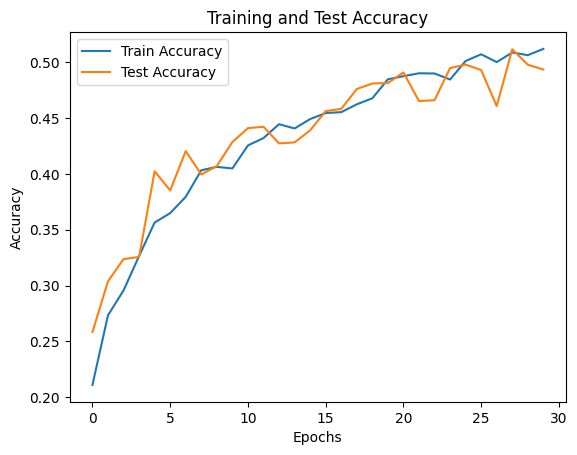

In [28]:
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

## 12. Getting Predictions

In [29]:
def predict(model, dataset, classes, grid_size = 3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9,9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset)-1)
            img, label = dataset[idx]
            true_label = label
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output, 1)
            img = img / 2 + 0.5
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n Predicted: {classes[predicted.item()]}", fontsize=10, c=color)

            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

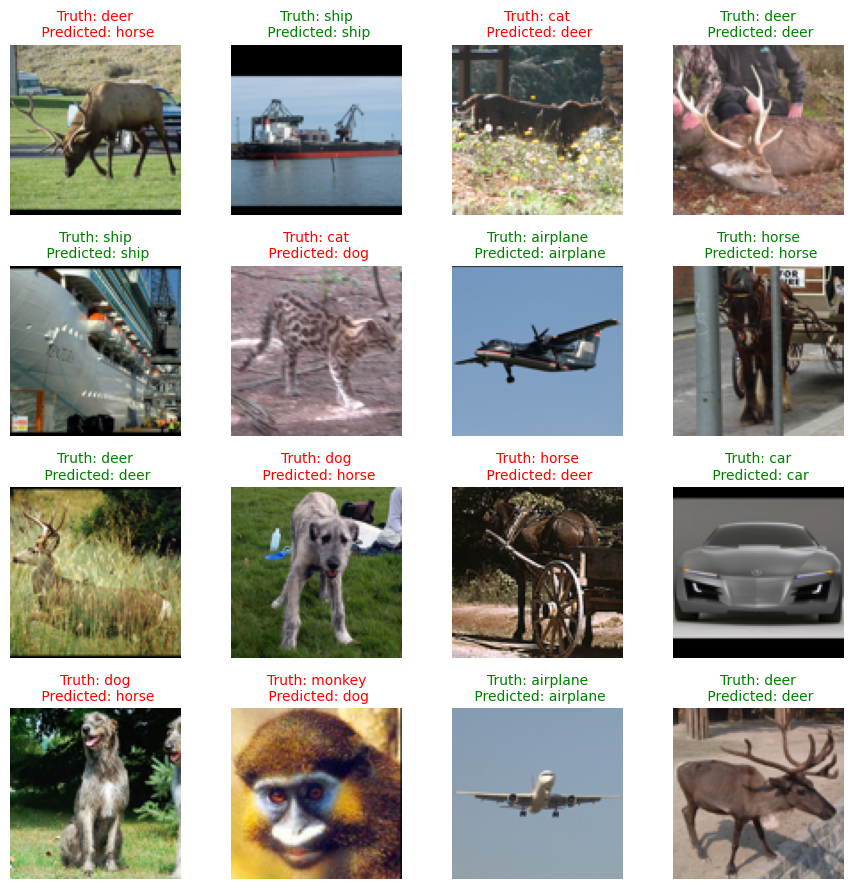

In [30]:
predict(
    model = model,
    dataset = test_data, 
    classes = train_data.classes,
    grid_size = 4
)

In [31]:
# save model weights
torch.save(model.state_dict(), "vit_stl10.pth")